In [1]:
#Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import optimizers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

In [2]:
fullsize_training_inputs = np.load('training_inputs.npy')
fullsize_training_ground_truth = np.load('training_ground_truth.npy')
fullsize_testing_inputs = np.load('testing_inputs.npy')
fullsize_testing_ground_truth = np.load('testing_ground_truth.npy')

In [3]:
#Resize images to something more manageable
def resize_tensor(tensor,size):
    '''resizes given tensor in the form [B,H,W,C] into a new tensor of size [B,H',W',C], using second order interpolation
    tensor: A four dimensional tensor object or numpy array
    size: A tuple of form (H',W')
    '''
    #unpack values
    N,H,W,C = tensor.shape
    new_H, new_W = size
    new_shape = (N,new_H, new_W, C)
    x, y = np.meshgrid(np.linspace(0,W,new_W),np.linspace(0,H,new_H))
    indices = np.reshape(y,(-1,1)), np.reshape(x,(-1,1))
    resized_tensor = np.empty(new_shape)
    for n in range(N):
        resized_image = map_coordinates(tensor[n,:,:,0],indices,order=1,mode='nearest')
        resized_image = resized_image.reshape(new_shape[1:3])
        resized_tensor[n] = resized_image[:,:,np.newaxis]
    return resized_tensor

def contrast_score(image):
    shape = image.shape
    low = np.sum(image < 0.1)
    high = np.sum(image > 0.9)
    return (low + high)/np.prod(shape)

In [4]:
new_shape = (192,256)
training_inputs = resize_tensor(fullsize_training_inputs,size = new_shape)/255
training_ground_truth = resize_tensor(fullsize_training_ground_truth,size = new_shape)/255
testing_inputs = resize_tensor(fullsize_testing_inputs,size = new_shape)/255
testing_ground_truth = resize_tensor(fullsize_testing_ground_truth,size = new_shape)/255
input_shape = training_inputs.shape

In [59]:
seed = 0
alpha = 10
sigma = 10
image_seed = 0
#Define some additional transormations
def elastic_transform(image):
    #alpha, sigma, random_state must be passed as global variables
    random_state = np.random.RandomState(image_seed)
    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape[:2])*2 - 1), sigma, mode = "constant",cval = 0)*alpha
    dy = gaussian_filter((random_state.rand(*shape[:2])*2 - 1), sigma, mode = "constant",cval = 0)*alpha
    
    x,y = np.meshgrid(np.arange(shape[1]),np.arange(shape[0]),np.arange(shape[2]))
    indices = np.reshape(y+dy,(-1,1)), np.reshape(x+dx,(-1,1))
    
    transformed_image = np.empty(shape)
    for c in range(shape[2]):
        transformed_image[c] = (map_coordinates(image[:,:,c],indices,order=1,mode='reflect')).reshape(shape[:2])
    return transformed_image

def random_noise(image):
    #add random_noise to the images
    #seed must be passed as a global variable
    random_state = np.random.RandomState(image_seed)
    noise_mag = random_state.normal()
    noise = tf.random.normal(shape = image.shape,
                             mean=0.0,
                             stddev=noise_mag
                            )
    transformed_image = image + noise
    return transformed_image

def additional_image_transformations(image):
    #randomly add noise and a deformation
    global image_seed
    image_seed = np.random.choice(1000)
    random_state = np.random.RandomState(image_seed)
    transformed_image = image
    alpha = random_state.uniform(low=50,high=200)
    sigma = alpha/2
    if random_state.choice(2) == 1:
        transformed_image = random_noise(transformed_image)
    if random_state.choice(2) == 1:
        transformed_image = elastic_transform(transformed_image)
    return transformed_image

def additional_mask_transformations(image):
    #randomly add a deformation
    random_state = np.random.RandomState(image_seed)
    transformed_image = image
    alpha = random_state.uniform(low=50,high=200)
    sigma = alpha/2
    if random_state.choice(2) == 1:
        pass
    if random_state.choice(2) == 1:
        transformed_image = elastic_transform(image)
    return transformed_image

In [65]:
# we create two instances with the same arguments
mask_gen_args = {'rotation_range':40,
                 'width_shift_range':0.1,
                 'height_shift_range':0.1,
                 'zoom_range':0.1,
                 'fill_mode':'reflect',
                 'horizontal_flip':True,
                 'vertical_flip':True
                 #'preprocessing_function':additional_mask_transformations
                }

image_gen_args = mask_gen_args.copy()
#image_gen_args.update({'featurewise_center':True,
#                       'featurewise_std_normalization':True
#                      })
#image_gen_args['preprocessing_function'] = additional_image_transformations

In [7]:
def conv_block(input_tensor, num_filters):
  encoder = layers.Conv2D(filters=num_filters, 
                          kernel_size=(3, 3), 
                          padding='same',
                          data_format='channels_last')(input_tensor)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(encoder)
  
  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(filters=num_filters, 
                                   kernel_size=(2, 2), 
                                   strides=(2, 2), 
                                   padding='same',
                                   data_format='channels_last')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  return decoder

In [8]:
inputs = layers.Input(shape = (192,256,1))
# 256

encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128

encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64

encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32

encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16

encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8

center = conv_block(encoder4_pool, 1024)
# center

decoder4 = decoder_block(center, encoder4, 512)
# 16

decoder3 = decoder_block(decoder4, encoder3, 256)
# 32

decoder2 = decoder_block(decoder3, encoder2, 128)
# 64

decoder1 = decoder_block(decoder2, encoder1, 64)
# 128

decoder0 = decoder_block(decoder1, encoder0, 32)
# 256

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

W1005 10:41:27.287577  7228 deprecation.py:506] From C:\Users\Malec\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [9]:
model = models.Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 192, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 192, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 192, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

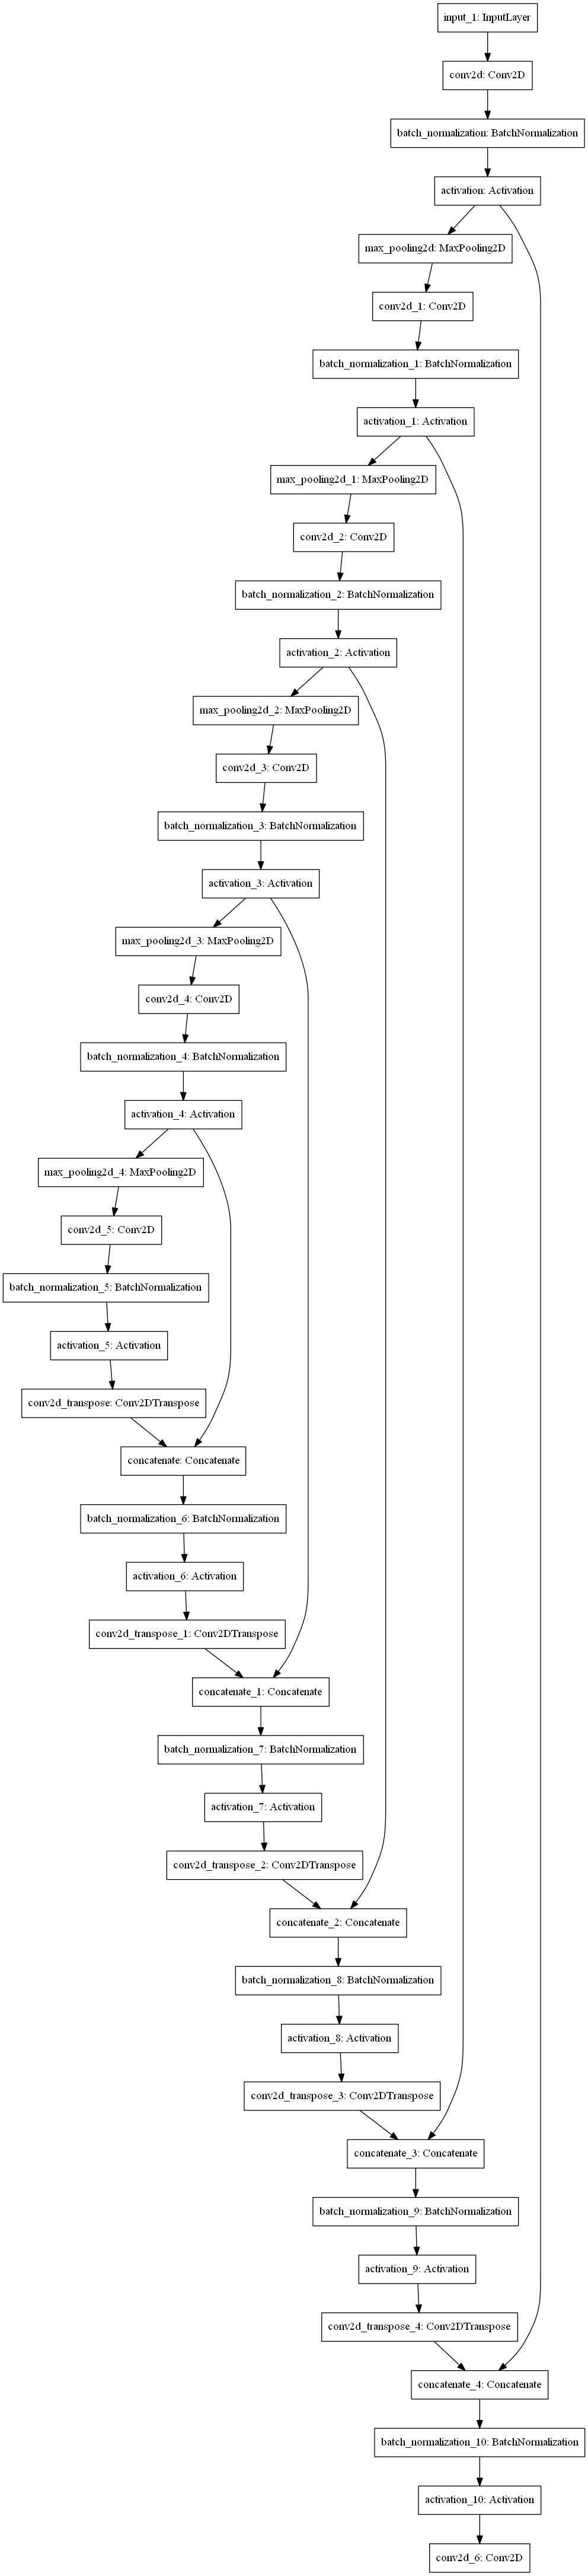

In [10]:
from tensorflow.keras.utils import plot_model

plot_model(model,to_file = 'model_plot.png',rankdir='TB')

In [11]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [66]:
model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_loss])

In [67]:
validation_inds = np.random.choice(range(165),20)
validation_inputs = testing_inputs[validation_inds,:,:,:]
validation_ground_truth = testing_ground_truth[validation_inds,:,:,:]

In [68]:
batch_size = 15
#seed = np.random.choice(range(1000))
seed = 153
print(seed)
#Instantiate Data Generators
image_datagen = ImageDataGenerator(**image_gen_args)
mask_datagen = ImageDataGenerator(**mask_gen_args)

#Find means and variances for some transforms
#image_datagen.fit(training_inputs)

image_generator = image_datagen.flow(
    training_inputs,
    batch_size=batch_size,
    seed=seed)

mask_generator = mask_datagen.flow(
    training_ground_truth,
    batch_size=batch_size,
    seed=seed)
                 
# combine generators into one which yields image and masks
train_generator = (pair for pair in zip(image_generator, mask_generator))

153


In [69]:
#Initiate Adam optimizer with default values
opt = optimizers.Adam()

#Compile model
model.compile(optimizer=opt, 
              loss=dice_loss, 
              metrics=[dice_coeff])

#Some parameters

epochs = 1

#Define a model callback
save_model_path = 'tmp/weights2.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, 
                                        monitor='val_loss',
                                        save_best_only=True, 
                                        verbose=1)

In [ ]:
#Fit the model
history = model.fit_generator(train_generator,
                              epochs=epochs,
                              steps_per_epoch = 11,
                              validation_data=(validation_inputs, validation_ground_truth),
                              shuffle=True,
                              callbacks=[cp]
                             )

 9/11 [=======================>......] - ETA: 21s - loss: 0.1699 - dice_coeff: 0.8301

In [48]:
# Score trained model.
test_indices = np.random.choice(range(165),5,replace=False)
scores = model.evaluate(testing_inputs[test_indices,:,:,:], 
                        testing_ground_truth[test_indices,:,:,:], 
                        verbose=1)

print('Test loss:', scores[0])

5/5 [==============================] - 0s 56ms/sample - loss: 0.6043 - dice_coeff: 0.3957
Test loss: 0.6042683720588684


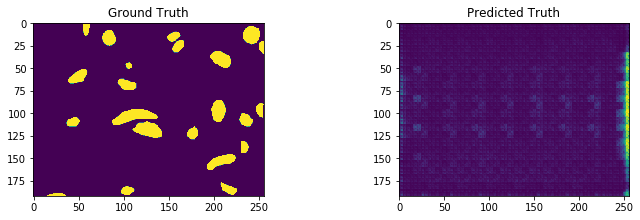

In [58]:
predict_mask = model.predict(training_inputs[:5,:,:,:])[0][:,:,0]
mask = training_ground_truth[0,:,:,0]
fig = plt.figure(figsize=[12,7])
ax1 = plt.subplot(2,2,1)
ax1.imshow(mask)
ax1.set_title('Ground Truth')
ax2 = plt.subplot(2,2,2)
ax2.imshow(predict_mask)
ax2.set_title('Predicted Truth')
plt.show()